In [59]:
# dependencies
import re
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from catboost import Pool, CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from category_encoders import TargetEncoder
from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [105]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
seed = 42

In [106]:
data = pd.concat((train, test)).reset_index(drop=True)

ID = test['Entry_id']
data.drop(['Entry_id'], inplace=True,axis=1)

In [107]:
data['risk_score'] = data.risk_score / 100000
data['risky'] = (data.risk_score > 0.5) & (data.risk_score_2 > 0.62) & (data.risk_score_3 < 0.8) & (data.risk_score_5 < 0.83)
data['get_signed'] = np.where(((data.risk_score > 0.596) & (data.income > 2750) & (data.amount_requested > 1300) & (data.ext_quality_score < 0.92)), 1, 0)

In [108]:
agg = ['mean', 'max', 'min', 'std']
for agg in agg:
    data[f'income_by_request_{agg}'] = data['income'].groupby(data['amount_requested']).transform(agg)
    data[f'risk_by_request_{agg}'] = data['risk_score'].groupby(data['amount_requested']).transform(agg)
    data[f'debt_by_request_{agg}'] = data['has_debt'].groupby(data['amount_requested']).transform(agg)

In [109]:
col_1 = ['risk_score', 'risk_score_2', 'risk_score_3']
col_2 = ['ext_quality_score', 'ext_quality_score_2']
data['risk_mean'] = data[col_1].mean(axis=1)
data['ext_mean'] = data[col_2].mean(axis=1)

In [110]:
data['income_per_request'] = data.income / data.amount_requested

In [111]:
data['month_acct'] = (data.personal_account_y * 12) + data.personal_account_m

In [112]:
data['age_group'] = pd.cut(x = data['age'], bins = [16, 28, 40, 64, 100], labels = ['young', 'young_adult', 'adult', 'old'])
data['class'] = pd.cut(x = data['income'], bins = [0, 3000, 7000, 10000], labels = ['poor', 'middle_class', 'rich'])
data['request_level'] = pd.cut(x = data['amount_requested'], bins = [0, 800, 1200, 5000, 12000], labels = ['one', 'two', 'three', 'four'])
data['risk_level'] = pd.cut(x = data['risk_mean'], bins = [0.4, 0.6, 0.7, 1], labels = ['one', 'two', 'three'])

In [113]:
cols = ['risk_level', 'age_group', 'pay_schedule', 'class', 'request_level', 'risky']
le = LabelEncoder()
for col in cols:
    data[col] = le.fit_transform(data[col])

In [114]:
# data.corr().abs()['e_signed']

In [115]:
train = data[data.e_signed.notnull()].reset_index(drop = True)
test = data[data.e_signed.isna()].reset_index(drop = True)
test.drop('e_signed', axis = 1, inplace = True)

In [116]:
train.shape, test.shape

((12516, 42), (5392, 41))

In [117]:
# X_, y_ = train[use], train['e_signed']
X, y = train.drop('e_signed', axis = 1), train['e_signed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .155, shuffle = True, random_state = seed)

# BASELINE MODEL

In [118]:
d_train, d_test  = Pool(X_train, y_train), Pool(X_test, y_test)
cb_model_ = CatBoostClassifier(max_depth = 5, learning_rate = 0.084, n_estimators = 1670, verbose = 0, random_state = seed)
cb_model_.fit(d_train, eval_set = [(d_test)], verbose = 0, early_stopping_rounds = 200)
preds_ = cb_model_.predict_proba(d_test)
auc(y_test, preds_[:,-1]).round(5)

0.72623

In [119]:
lgb_model_ = LGBMClassifier(n_estimators = 2000, learning_rate = 0.01, colsample_bytree = 0.8, max_depth = 6, random_state = seed, verbose = -1)
lgb_model_.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], early_stopping_rounds = 200, verbose = 0)
preds_ = lgb_model_.predict_proba(X_test)
auc(y_test, preds_[:,-1]).round(5)

0.72374

# CROSS VALIDATION

In [120]:
# creating fols to n=be used for cross validation
TARGET_COL = 'e_signed'
remove_features = ['e_signed', 'folds']
features_columns = [col for col in train.columns if col not in remove_features]
cat = le.fit_transform(train.e_signed)
def create_folds(data):
    data["folds"] = -1
    data = data.sample(frac = 1).reset_index(drop = True)
    num_bins = np.floor(1 + np.log2(len(train))).astype(int)
    data.loc[:, "bins"] = pd.cut(cat, bins = num_bins, labels = False)
    kf = KFold(n_splits = 10, random_state = 10, shuffle = True)
    for f, (t_, v_) in enumerate(kf.split(X = data, y = data.bins.values)):
        data.loc[v_, "folds"] = f
    data.drop("bins", axis = 1, inplace = True)
    return data
train = create_folds(train)

In [121]:
cb_auc_score_ = []
# prediction_1 = []
n_splits = 10
print("-" * 30)
for fold in range(n_splits):
    x_train_, y_train_ = train[train['folds']!=fold][features_columns] , train[train['folds']!=fold][TARGET_COL] 
    x_test_, y_test_ = train[train['folds']==fold][features_columns] , train[train['folds']==fold][TARGET_COL] 
    model_cb_ = CatBoostClassifier(max_depth = 5, bootstrap_type = 'Bayesian', learning_rate = 0.09, n_estimators = 500, verbose = 0, random_state = seed)
    model_cb_.fit(x_train_, y_train_, eval_set = [(x_train_, y_train_), (x_test_, y_test_)], early_stopping_rounds = 300, verbose = 0)
    preds_ = model_cb_.predict_proba(x_test_)
    # prediction_1.append(model_cb_.predict_proba(test))
    auc_1 = auc(y_test_, preds_[:,-1]).round(5)
    print(f'AUC_{fold + 1}: {auc_1}')
    cb_auc_score_.append(auc_1)
    print("-" * 30)
print('\n')
print(f"AUC_CV_CB: {np.mean(cb_auc_score_).round(5)}")

------------------------------
AUC_1: 0.72688
------------------------------
AUC_2: 0.72434
------------------------------
AUC_3: 0.72506
------------------------------
AUC_4: 0.72973
------------------------------
AUC_5: 0.73478
------------------------------
AUC_6: 0.71696
------------------------------
AUC_7: 0.72161
------------------------------
AUC_8: 0.73327
------------------------------
AUC_9: 0.70315
------------------------------
AUC_10: 0.72383
------------------------------


AUC_CV_CB: 0.72396


In [122]:
lb_auc_score_ = []
prediction_2 = []
print("-" * 30)
n_splits = 10
for fold in range(n_splits):
    x_train_, y_train_ = train[train['folds']!=fold][features_columns] , train[train['folds']!=fold][TARGET_COL] 
    x_test_, y_test_ = train[train['folds']==fold][features_columns] , train[train['folds']==fold][TARGET_COL] 
    d_train = Pool(x_train_, y_train_)
    d_test = Pool(x_test_, y_test_)
    model_lgb_ = LGBMClassifier(n_estimators = 2000, learning_rate = 0.08, colsample_bytree = 0.8, max_depth = 6, random_state = seed, verbose = -1)
    model_lgb_.fit(x_train_, y_train_, eval_set = [(x_train_, y_train_), (x_test_, y_test_)], early_stopping_rounds = 300, verbose = 0)
    preds_ = model_lgb_.predict_proba(x_test_)
    prediction_2.append(model_lgb_.predict_proba(test))
    auc_2 = auc(y_test_, preds_[:, -1]).round(5)
    print(f'AUC_{fold + 1}: {auc_2}')
    lb_auc_score_.append(auc_2)
    print("-" * 30)
print('\n')
print(f"AUC_CV_LB: {np.mean(lb_auc_score_).round(5)}")

------------------------------
AUC_1: 0.71597
------------------------------
AUC_2: 0.72715
------------------------------
AUC_3: 0.71752
------------------------------
AUC_4: 0.73047
------------------------------
AUC_5: 0.72947
------------------------------
AUC_6: 0.71508
------------------------------
AUC_7: 0.72529
------------------------------
AUC_8: 0.72759
------------------------------
AUC_9: 0.70186
------------------------------
AUC_10: 0.71938
------------------------------


AUC_CV_LB: 0.72098


In [123]:
pred_1 = model_cb_.predict_proba(test)[:, -1]
pred_2 = model_lgb_.predict_proba(test)[:, -1]
pred_3 = cb_model_.predict_proba(test)[:, -1]
pred_4 = lgb_model_.predict_proba(test)[:, -1]

In [124]:
pred = (pred_1 + pred_2 + pred_3 + pred_4) / 4

In [125]:
d_ = {'Entry_id' : ID, 'e_signed' : pred}
df_ = pd.DataFrame(data = d_)
df_ = df_[['Entry_id', 'e_signed']]
df_.to_csv('datafest_aisquad.csv', index = False)

In [126]:
df_.head()

,Entry_id,e_signed
0,3560428,0.424568
1,6934997,0.840020
2,5682812,0.491549
3,6493191,0.800437
4,8990111,0.301299


In [36]:
df_.head()

,Entry_id,e_signed
0,3560428,0.407537
1,6934997,0.852427
2,5682812,0.539748
3,6493191,0.787278
4,8990111,0.294801


# Neural Network

In [222]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [223]:
X = StandardScaler().fit_transform(X)

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .155, shuffle = True, random_state = seed)

In [231]:
# X_train.shape

In [232]:
model = Sequential()
model.add(Dense(3, activation = 'relu', input_dim = 43, use_bias=True, bias_initializer='zeros'))
model.add(Dense(256, activation = 'sigmoid'))
model.add(Dense(1, activation = 'sigmoid'))

In [233]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', 
    verbose=4,
    patience=10,
    mode='max',
    restore_best_weights=True)

model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=keras.metrics.AUC(name='auc'))

In [234]:
history = model.fit(X_train, y_train, 
                    epochs = 50, batch_size = 200, 
                    validation_split = 0.10, 
                    shuffle = True, callbacks=[early_stopping],)

Epoch 1/50
48/48 [==============================] - 2s 14ms/step - loss: 0.6892 - auc: 0.5356 - val_loss: 0.6753 - val_auc: 0.5939
Epoch 2/50
48/48 [==============================] - 0s 5ms/step - loss: 0.6773 - auc: 0.5774 - val_loss: 0.6705 - val_auc: 0.6105
Epoch 3/50
48/48 [==============================] - 0s 5ms/step - loss: 0.6704 - auc: 0.6039 - val_loss: 0.6605 - val_auc: 0.6277
Epoch 4/50
48/48 [==============================] - 0s 5ms/step - loss: 0.6648 - auc: 0.6212 - val_loss: 0.6572 - val_auc: 0.6396
Epoch 5/50
48/48 [==============================] - 0s 5ms/step - loss: 0.6582 - auc: 0.6381 - val_loss: 0.6496 - val_auc: 0.6462
Epoch 6/50
48/48 [==============================] - 0s 5ms/step - loss: 0.6538 - auc: 0.6477 - val_loss: 0.6459 - val_auc: 0.6522
Epoch 7/50
48/48 [==============================] - 0s 5ms/step - loss: 0.6505 - auc: 0.6539 - val_loss: 0.6445 - val_auc: 0.6569
Epoch 8/50
48/48 [==============================] - 0s 5ms/step - loss: 0.6489 - auc: 0.6

In [237]:
# a = model.evaluate(X_test, y_test)

In [243]:
a = model.predict(X_test)

61/61 [==============================] - 0s 3ms/step


In [247]:
# auc(a[:,0], y_test)

In [248]:
test = StandardScaler().fit_transform(test)

In [249]:
pred = model.predict(test)

169/169 [==============================] - 0s 2ms/step


In [250]:
d_ = {'Entry_id' : ID, 'e_signed' : pred[:,0]}
df_ = pd.DataFrame(data = d_)
df_ = df_[['Entry_id', 'e_signed']]
df_.to_csv('datafest_aisquad_nn.csv', index = False)

In [251]:
df_.head()

,Entry_id,e_signed
0,3560428,0.429999
1,6934997,0.885229
2,5682812,0.489401
3,6493191,0.771760
4,8990111,0.429271


# Get

In [913]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from torch.nn import functional as F

In [914]:
# convert the data from the numpy array to tensor

X_train = torch.tensor(X_train.values).float()
y_train = torch.tensor(y_train.values).long().reshape(-1,1)

X_test = torch.tensor(X_test.values).float()
y_test = torch.tensor(y_test.values).long().reshape(-1,1)

# Convert the splitted data of tensors to TensorDataset
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# From the tensordata set to mini batches 
train_data = DataLoader( train_data, 
                        batch_size= int(X_train.shape[0]/10),  # the data set will be devided into n equal mini batches
                       shuffle= True, 
                       drop_last= True)

test_data = DataLoader( test_data, shuffle = True )

In [915]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        # input layer 
        self.input = nn.Linear(X_train.shape[1], 8)
        
        # dense layer 
        
        self.BN1 = nn.BatchNorm1d(8)
        self.dense1 = nn.Linear(8,32)
        
        self.BN2 = nn.BatchNorm1d(32)
        self.dense2 = nn.Linear(32,64)
        
        self.BN3 = nn.BatchNorm1d(64)
        self.dense3 = nn.Linear(64, 32)
        
        self.BN4 = nn.BatchNorm1d(32)
        self.dense4 = nn.Linear(32, 8)
        
        # Output Layer 
        self.output = nn.Linear(8, 2)
        
    def forward(self, x):
        
        x = F.leaky_relu( self.input(x) )
        
        x = self.BN1(x)
        x = F.leaky_relu(self.dense1(x))
        x = F.dropout(x, p = 0.2 , training= self.training )
        
        x = self.BN2(x)
        x = F.leaky_relu(self.dense2(x))
        x = F.dropout(x, p = 0.3 , training= self.training )
        
        x = self.BN3(x)
        x = F.leaky_relu(self.dense3(x))
        x = F.dropout(x, p = 0.2 , training= self.training )
        
        x = self.BN4(x)
        x = F.leaky_relu(self.dense4(x))
        x = F.dropout(x, p = 0.6 , training= self.training )
        
        x = self.output(x)
        return x

In [916]:
# create a instance of a class
model = Classifier()

# loss function 
loss_fun = nn.CrossEntropyLoss()


# optimizer 
optimizer = torch.optim.Adam(model.parameters() , lr= 0.001, weight_decay= 0.01)  

In [917]:
def model_train_and_validation(model, epoch):
    
    train_acc = []
    test_acc = []
    
    train_loss = []
    test_loss = []
    # loop over every epoch
    for epochi in range(epoch):
        
        # loop over traing data batches
        bach_acc = []
        bach_loss = []
        for x,y in train_data: 
            
            # forward propogation
            yHat = model(x) 
            
            # loss 
            loss = loss_fun(yHat, torch.squeeze(y) )
            bach_loss.append(loss.detach().numpy())
            
            
            # back propogation 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
            # compute batch accuracy 
            bach_acc.append( auc(torch.argmax( yHat,dim =1) ,y) )
            
            
        # compute training accuracy and loss
        train_acc.append(np.mean(bach_acc))
        train_loss.append( np.mean(bach_loss) )
        
        # evaluation mode on
        model.eval()
        
        """
        x,y = next(iter( test_data ) )
        yHat = F.softmax(model(x), dim =1)
        """
        test_acc.append( auc( torch.argmax(  F.softmax( model(X_test)), dim =1), y_test) )
        test_loss.append( loss_fun( model(X_test), torch.squeeze(y_test) ).detach().numpy() )
        # model back to train mode
        model.train()
        
        print(f" Epoch : {epochi}, Train AUC : {train_acc[epochi]}, Train Loss : {train_loss[epochi]} ")
        
    model.eval()  
    return train_acc, train_loss, test_acc, test_loss

In [918]:
train_acc, train_loss, test_acc, test_loss = model_train_and_validation(model, 100)

 Epoch : 0, Train AUC : 0.5146259430453002, Train Loss : 0.7177788615226746 
 Epoch : 1, Train AUC : 0.5292625402708658, Train Loss : 0.6982429623603821 
 Epoch : 2, Train AUC : 0.5254403867428021, Train Loss : 0.695320725440979 
 Epoch : 3, Train AUC : 0.535790631716152, Train Loss : 0.6871007680892944 
 Epoch : 4, Train AUC : 0.5326225412345913, Train Loss : 0.6857813000679016 
 Epoch : 5, Train AUC : 0.5284139244198826, Train Loss : 0.6840848922729492 
 Epoch : 6, Train AUC : 0.5359260600308442, Train Loss : 0.6794768571853638 
 Epoch : 7, Train AUC : 0.5371910663498547, Train Loss : 0.6790865659713745 
 Epoch : 8, Train AUC : 0.5296219190788073, Train Loss : 0.6774458885192871 
 Epoch : 9, Train AUC : 0.546532003362072, Train Loss : 0.6758118867874146 
 Epoch : 10, Train AUC : 0.5418799002077505, Train Loss : 0.6760997176170349 
 Epoch : 11, Train AUC : 0.5351844332176189, Train Loss : 0.6753140687942505 
 Epoch : 12, Train AUC : 0.541866307304536, Train Loss : 0.6745738387107849 


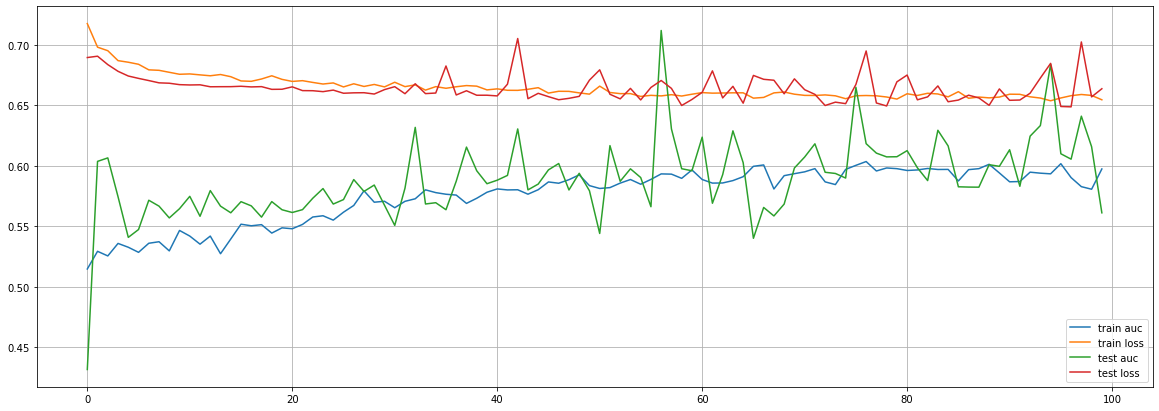

In [919]:
plt.figure(figsize= (20,7))

plt.plot(train_acc, label = "train auc")
plt.plot( train_loss, label = "train loss" )
plt.plot( test_acc, label = "test auc" )
plt.plot( test_loss, label = "test loss" )
plt.legend()
plt.grid()
plt.show()

In [890]:
model(test)

Classifier(
  (input): Linear(in_features=38, out_features=16, bias=True)
  (BN1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense1): Linear(in_features=16, out_features=32, bias=True)
  (BN2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense2): Linear(in_features=32, out_features=64, bias=True)
  (BN3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense3): Linear(in_features=64, out_features=32, bias=True)
  (BN4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense4): Linear(in_features=32, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=2, bias=True)
)